# Code 7: Bayesian Additive Regression Trees

```{admonition} This is a reference notebook for the book Bayesian Modeling and Computation in Python
:class: tip, dropdown
The textbook is not needed to use or run this code, though the context and explanation is missing from this notebook.

If you'd like a copy it's available
[from the CRC Press](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368)
or from [Amazon](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368).
``

In [1]:
%matplotlib inline
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import arviz as az
from scipy.special import expit

from scr.pdp import plot_pdp

In [2]:
az.style.use('arviz-grayscale')
plt.rcParams["figure.dpi"] = 300
np.random.seed(5453)
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1843137254901961, 0.4196078431372549, 0.5568627450980392, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

## Notes
7.0 Intro
+ More "fire & forget"
+ Combine multiple wek learners to make an ensemble model
+ Decision trees can easily ovefit, so we add a regularizing prior to make each tree behave as a weak learner.
7.1 Decision Trees
+ Can be thought of as a series of IF-ELSE statements that split the data into categegories
+ Decision Tree - Classification
![alt text](img/chp07/decision_tree.png "Title")
+ Decision Tree - Regression
![alt text](img/chp07/decision_tree_reg.png "Title")

## BART Bikes

In [3]:
data = pd.read_csv("data/bikes_hour.csv")
data.sort_values(by="hour", inplace=True)
data

instant      dteday  season  yr  mnth  hour  holiday  weekday  \
0            1  2011-01-01       1   0     1     0        0        6   
5653      5654  2011-08-29       3   0     8     0        0        1   
5618      5619  2011-08-27       3   0     8     0        0        6   
5594      5595  2011-08-26       3   0     8     0        0        5   
5570      5571  2011-08-25       3   0     8     0        0        4   
...        ...         ...     ...  ..   ...   ...      ...      ...   
7568      7569  2011-11-16       4   0    11    23        0        3   
7544      7545  2011-11-15       4   0    11    23        0        2   
7520      7521  2011-11-14       4   0    11    23        0        1   
7832      7833  2011-11-27       4   0    11    23        0        0   
17378    17379  2012-12-31       1   1    12    23        0        1   

       workingday  weathersit  temperature   atemp  humidity  windspeed  \
0               0           1         0.24  0.2879      0.81     0.0000   
5653            1           1         0.62  0.5909      0.73     0.1045   
5618            0           1         0.70  0.6667      0.84     0.1045   
5594            1           1         0.62  0.5758      0.83     0.1343   
5570            1           1         0.68  0.6364      0.74     0.2985   
...           ...         ...          ...     ...       ...        ...   
7568            1           3         0.42  0.4242      0.88     0.1343   
7544            1           2         0.46  0.4545      0.94     0.1045   
7520            1           1         0.56  0.5303      0.64     0.2985   
7832            0           1         0.48  0.4697      0.72     0.2537   
17378           1           1         0.26  0.2727      0.65     0.1343   

       casual  registered  count  
0           3          13     16  
5653       13          21     34  
5618       33         112    145  
5594        9          42     51  
5570       11          41     52  
...       ...         ...    ...  
7568        3          28     31  
7544       14          66     80  
7520       13          48     61  
7832        5          27     32  
17378      12          37     49  

[17379 rows x 17 columns]

In [4]:
# We standardize the response variable
data_cnt_om = data["count"].mean()
data_cnt_os = data["count"].std()
data["count_normalized"] = (data["count"] - data_cnt_om) / data_cnt_os
# Remove data, you may later try to refit the model to the whole data
data = data[::50]

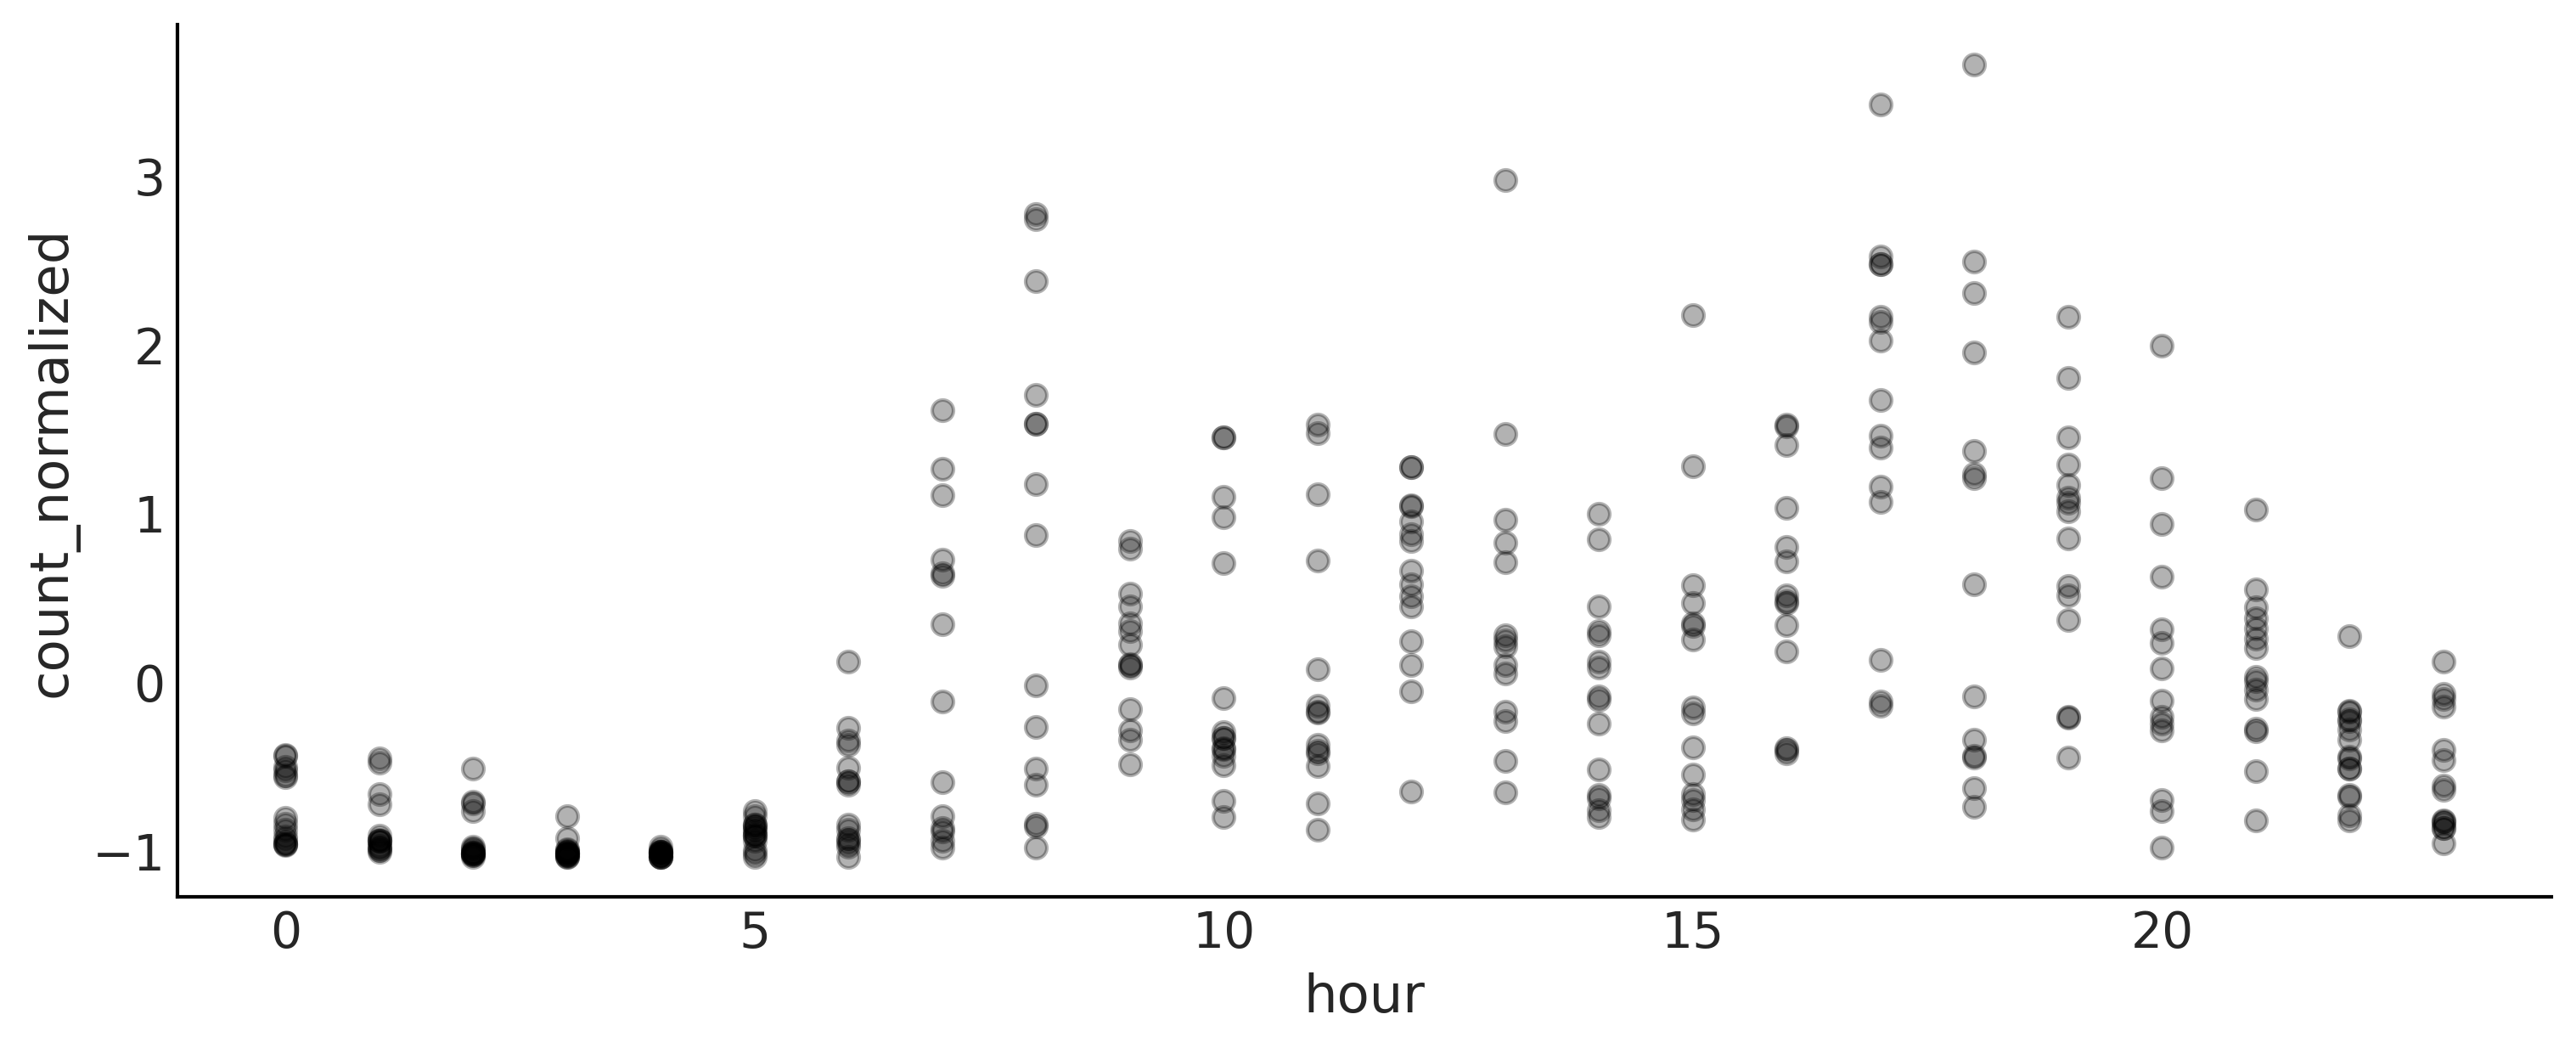

In [5]:
_, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(data.hour, data.count_normalized, "o", alpha=0.3)
ax.set_xlabel("hour")
ax.set_ylabel("count_normalized")
plt.savefig('img/chp05/bikes_data.png');

In [6]:
data = pd.read_csv("data/bikes_hour.csv")
data = data[::50]
data.sort_values(by='hour', inplace=True)
data.hour.values.astype(float)

X = np.atleast_2d(data["hour"]).T
Y = data["count"]

In [7]:
X[0:5]

array([[0],
       [0],
       [0],
       [0],
       [0]])

In [8]:
Y.head()

0        16
4850     28
5450    128
3650     29
6250     52
Name: count, dtype: int64

### Code 7.1

In [9]:
with pm.Model() as bart_g:
    σ = pm.HalfNormal('σ', Y.std())
    μ = pm.BART('μ', X, Y, m=50)
    y = pm.Normal('y', μ, σ, observed=Y)
    idata_bart_g = pm.sample(2000, chains=1, return_inferencedata=True)

The BART model is experimental. Use with caution.
Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 31 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [10]:
idata_bart_g

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [11]:
az.plot_trace(idata_bart_g);

In [12]:
μ.distribution.all_trees[0][1].predict_output()

array([-18.87812179, -18.87812179, -18.87812179, -18.87812179,
       -18.87812179, -18.87812179, -18.87812179, -18.87812179,
       -18.87812179, -18.87812179, -18.87812179, -18.87812179,
       -18.87812179, -18.87812179, -18.87812179, -18.87812179,
       -18.87812179, -18.87812179, -18.87812179, -18.87812179,
       -18.87812179, -18.87812179, -18.87812179, -18.87812179,
       -18.87812179, -18.87812179, -18.87812179, -18.87812179,
       -18.87812179, -18.87812179, -18.87812179, -18.87812179,
       -18.87812179, -18.87812179, -18.87812179, -18.87812179,
       -18.87812179, -18.87812179, -18.87812179, -18.87812179,
       -18.87812179, -18.87812179, -18.87812179, -18.87812179,
       -18.87812179, -18.87812179, -18.87812179, -18.87812179,
       -18.87812179, -18.87812179, -18.87812179, -18.87812179,
       -18.87812179, -18.87812179, -18.87812179, -18.87812179,
       -18.87812179, -18.87812179, -18.87812179, -18.87812179,
       -18.87812179, -18.87812179, -18.87812179, -18.87

### Figure 7.4

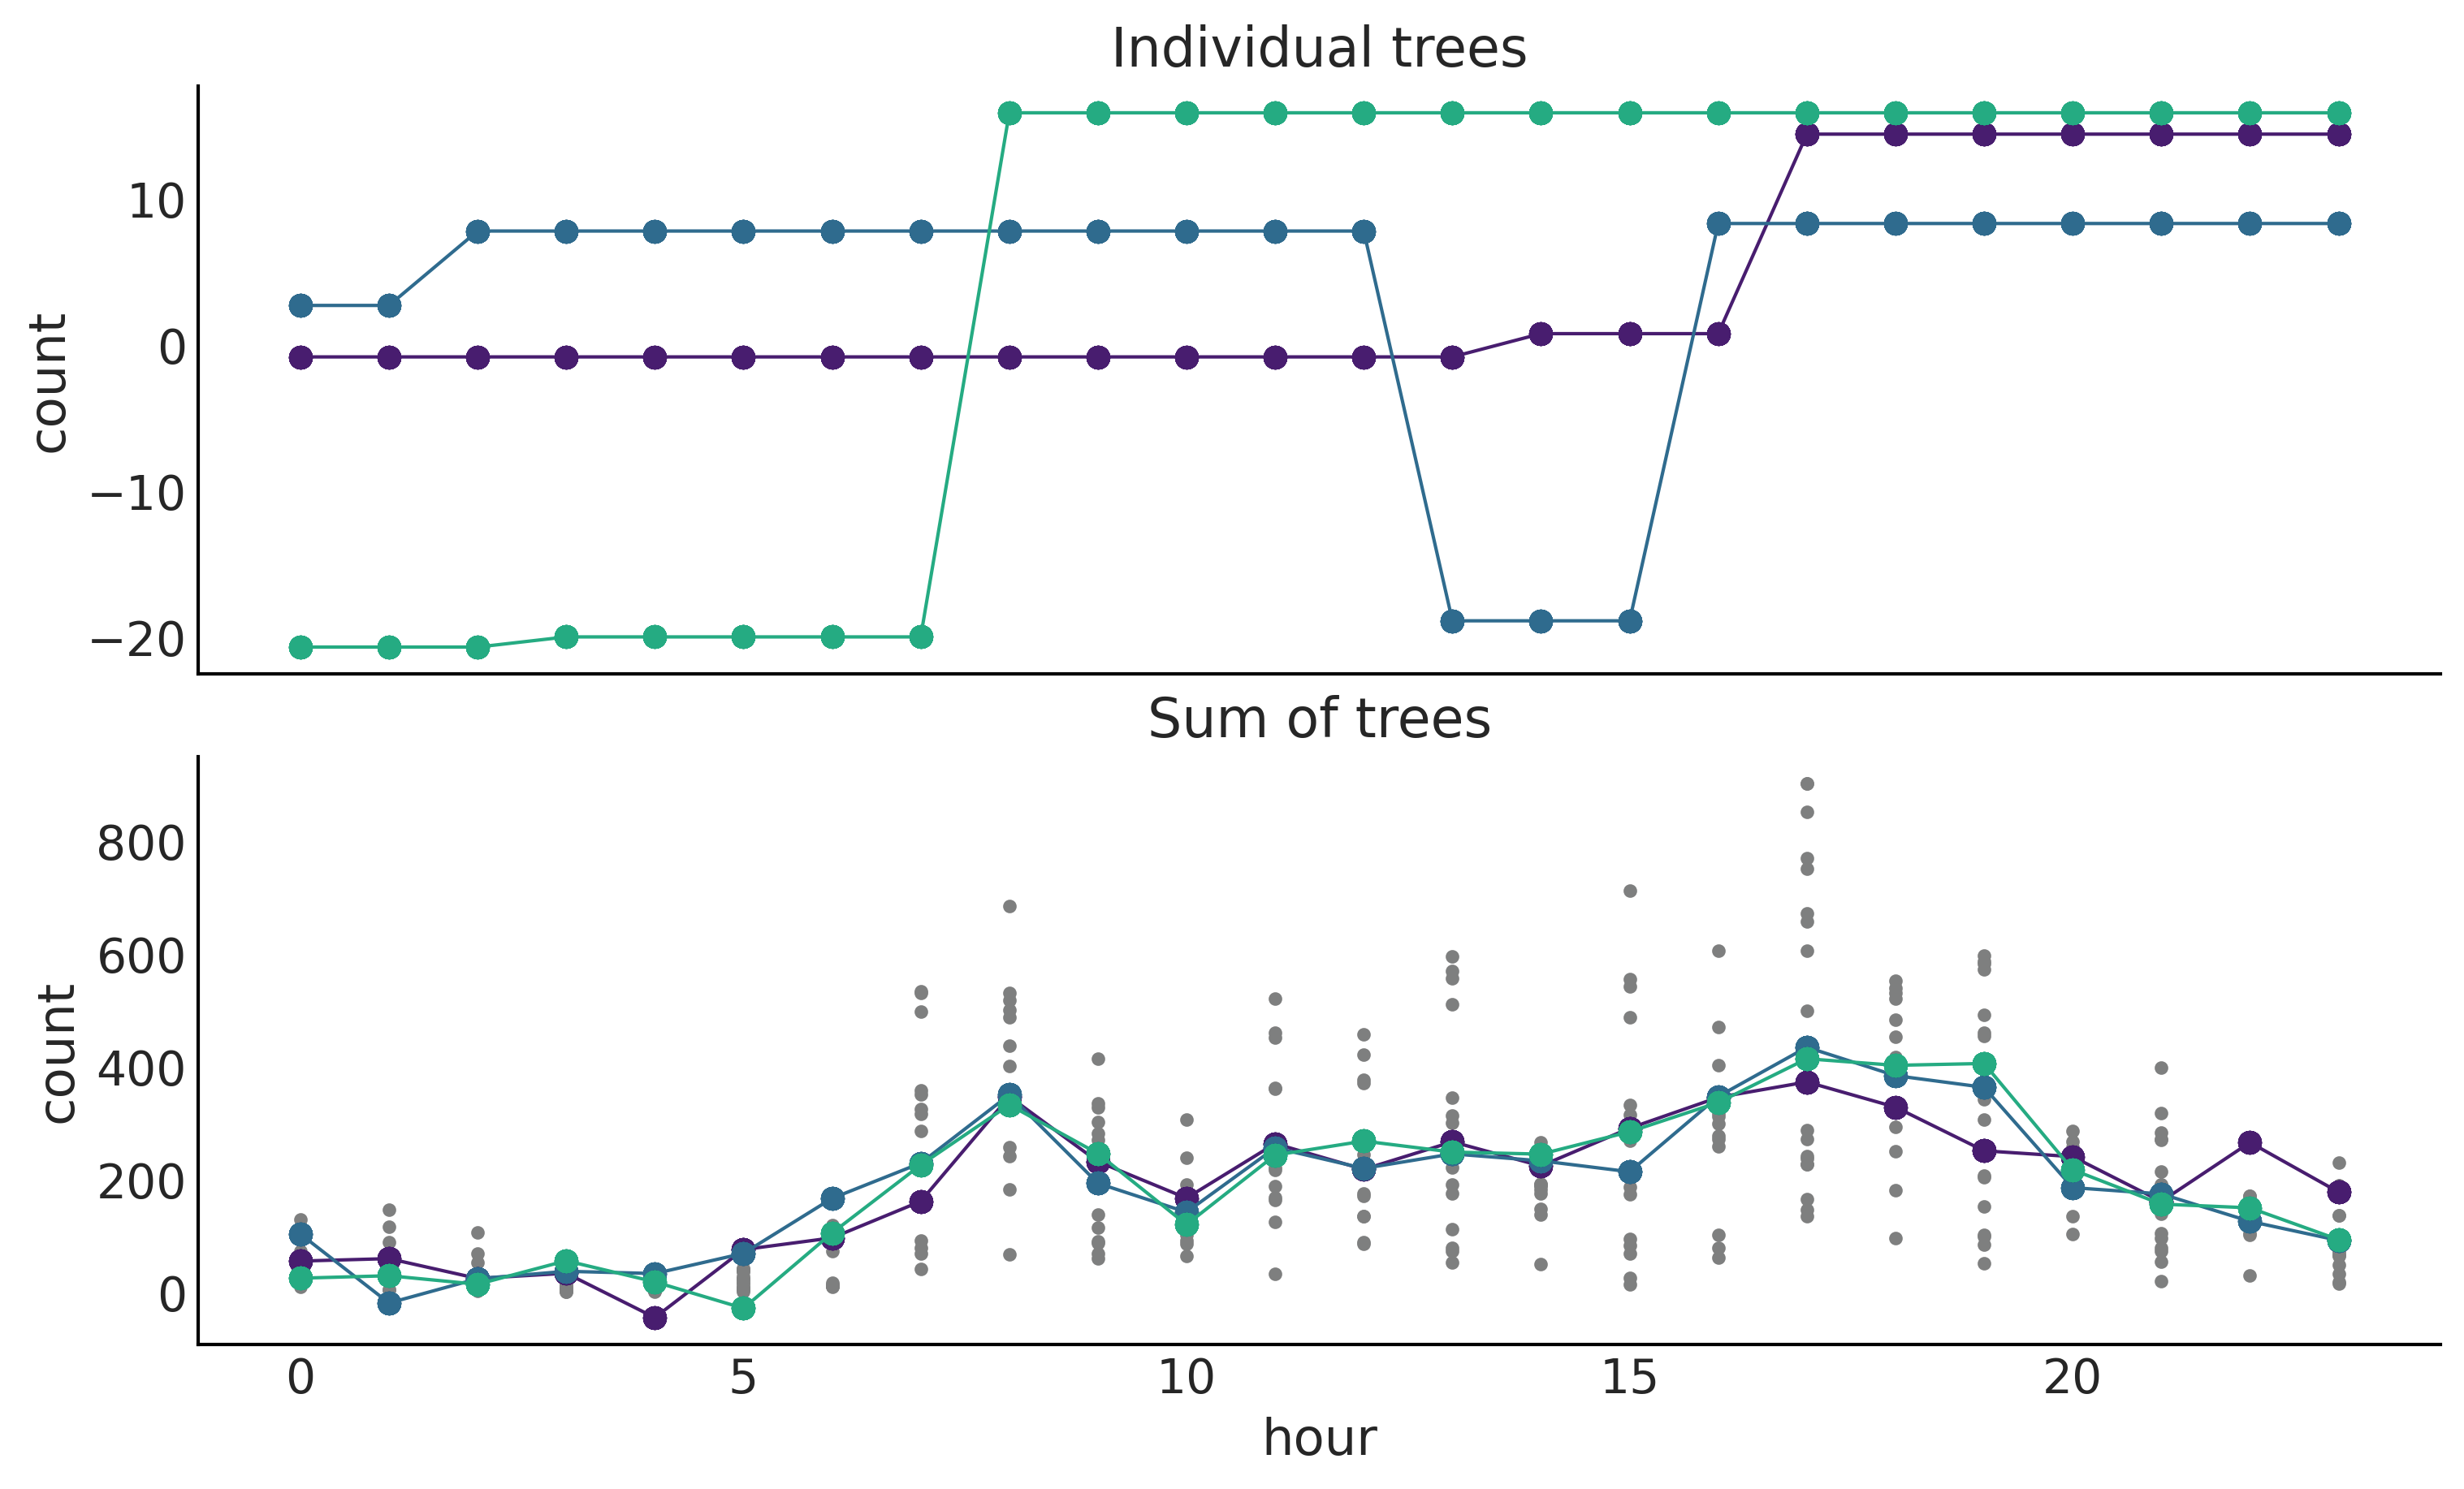

In [13]:
_, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax[0].set_prop_cycle(cycler('color', viridish))
ax[1].set_prop_cycle(cycler('color', viridish))
for i in range(3):
    ax[0].plot(X, μ.distribution.all_trees[i*10][i*2].predict_output(), "o-", lw=1)

posterior = idata_bart_g.posterior.stack(samples=("chain", "draw"))
for i in range(3):
    ax[1].plot(X, posterior["μ"].sel(draw=i*50), "o-", lw=1)
ax[1].plot(X, Y, "C2.", zorder=-1)

    
ax[0].set_ylabel("count")
ax[0].set_title("Individual trees")
ax[1].set_title("Sum of trees")
ax[1].set_xlabel("hour")
ax[1].set_ylabel("count")
# plt.savefig('img/chp07/BART_bikes_samples.png')
plt.show();

### Code 7.5

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


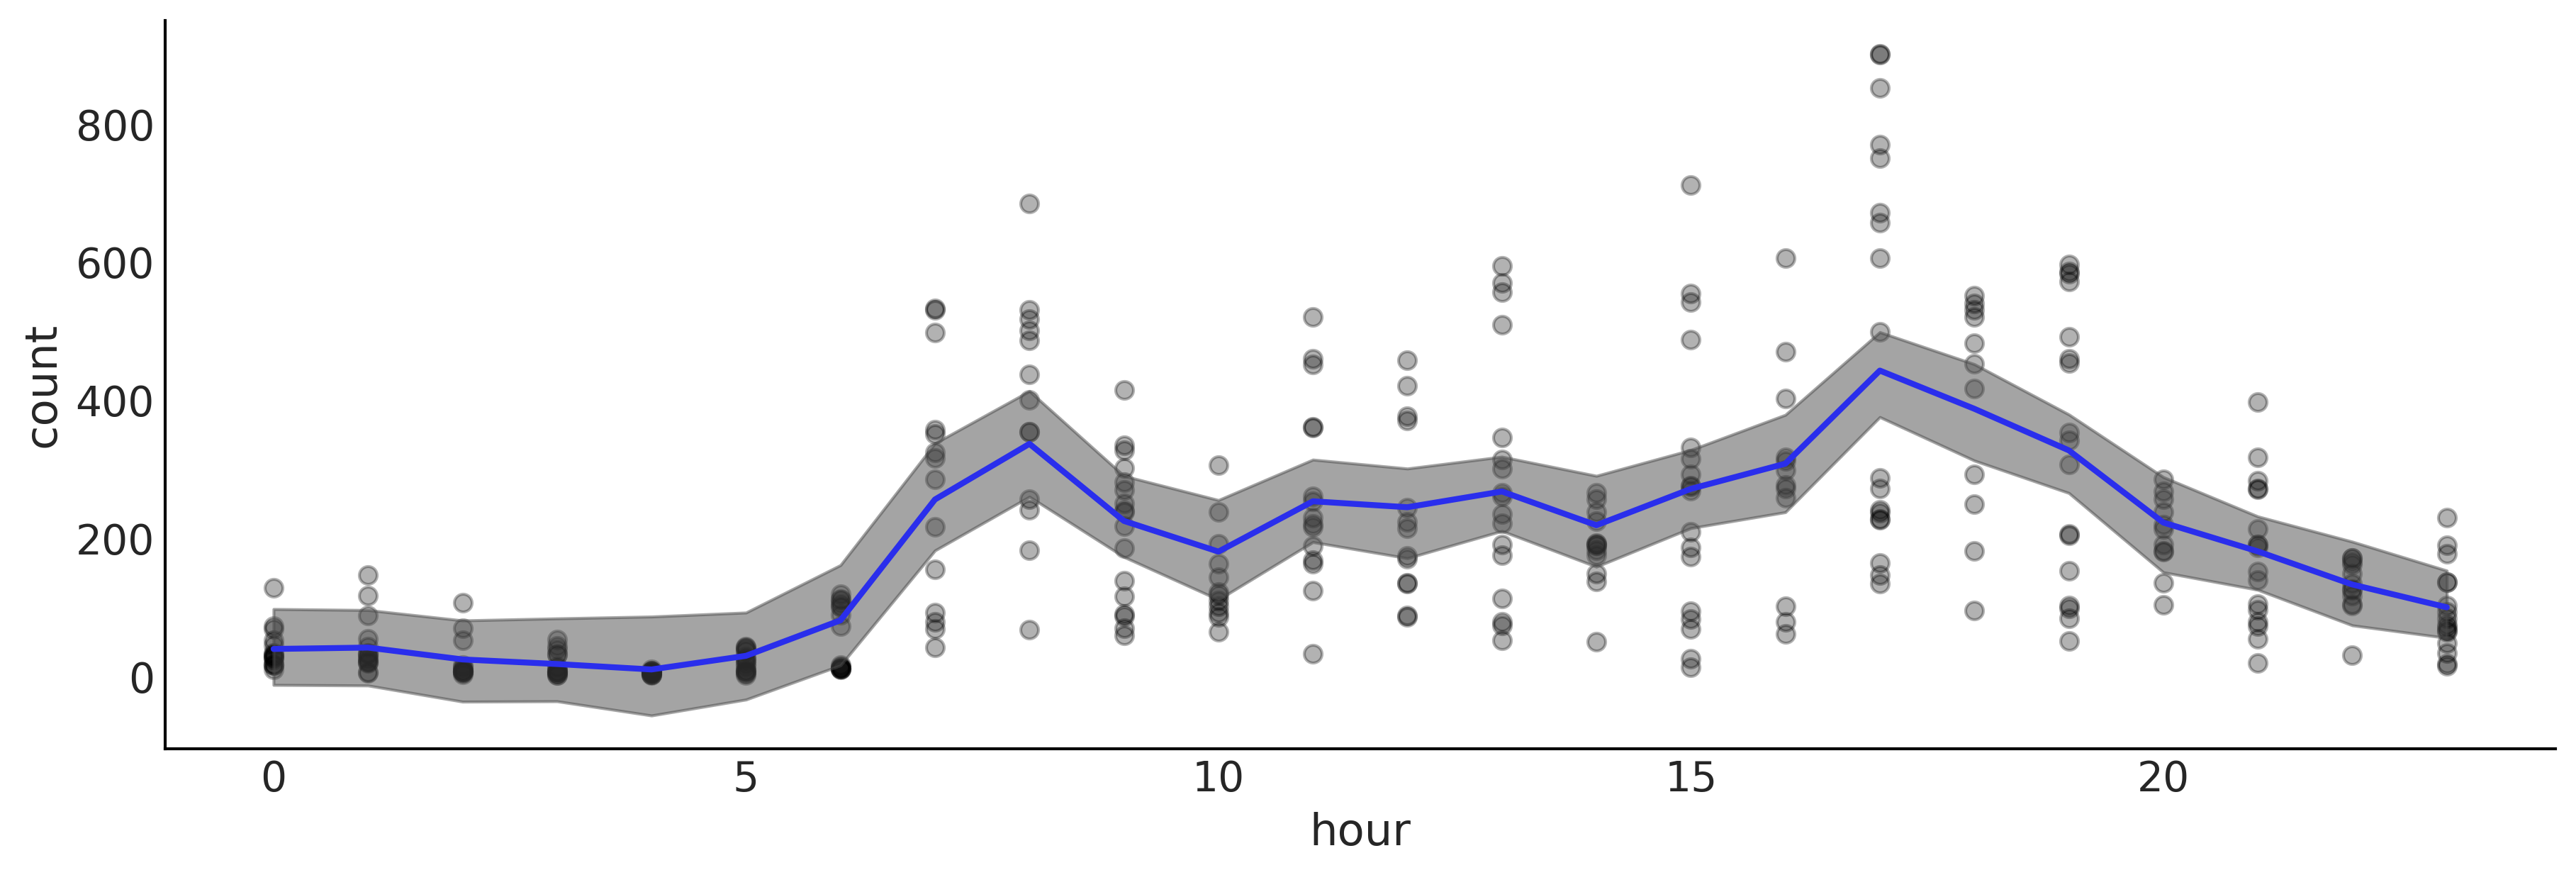

In [14]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.plot(X, Y, "o", alpha=0.3, zorder=-1)
ax.plot(X,  posterior["μ"].mean("samples"), color="C4", lw=2)
az.plot_hdi(X[:,0], posterior["μ"].T, smooth=False)

ax.set_xlabel("hour")
ax.set_ylabel("count")
# plt.savefig('img/chp07/BART_bikes.png')
plt.show();

## Generalized BART Models

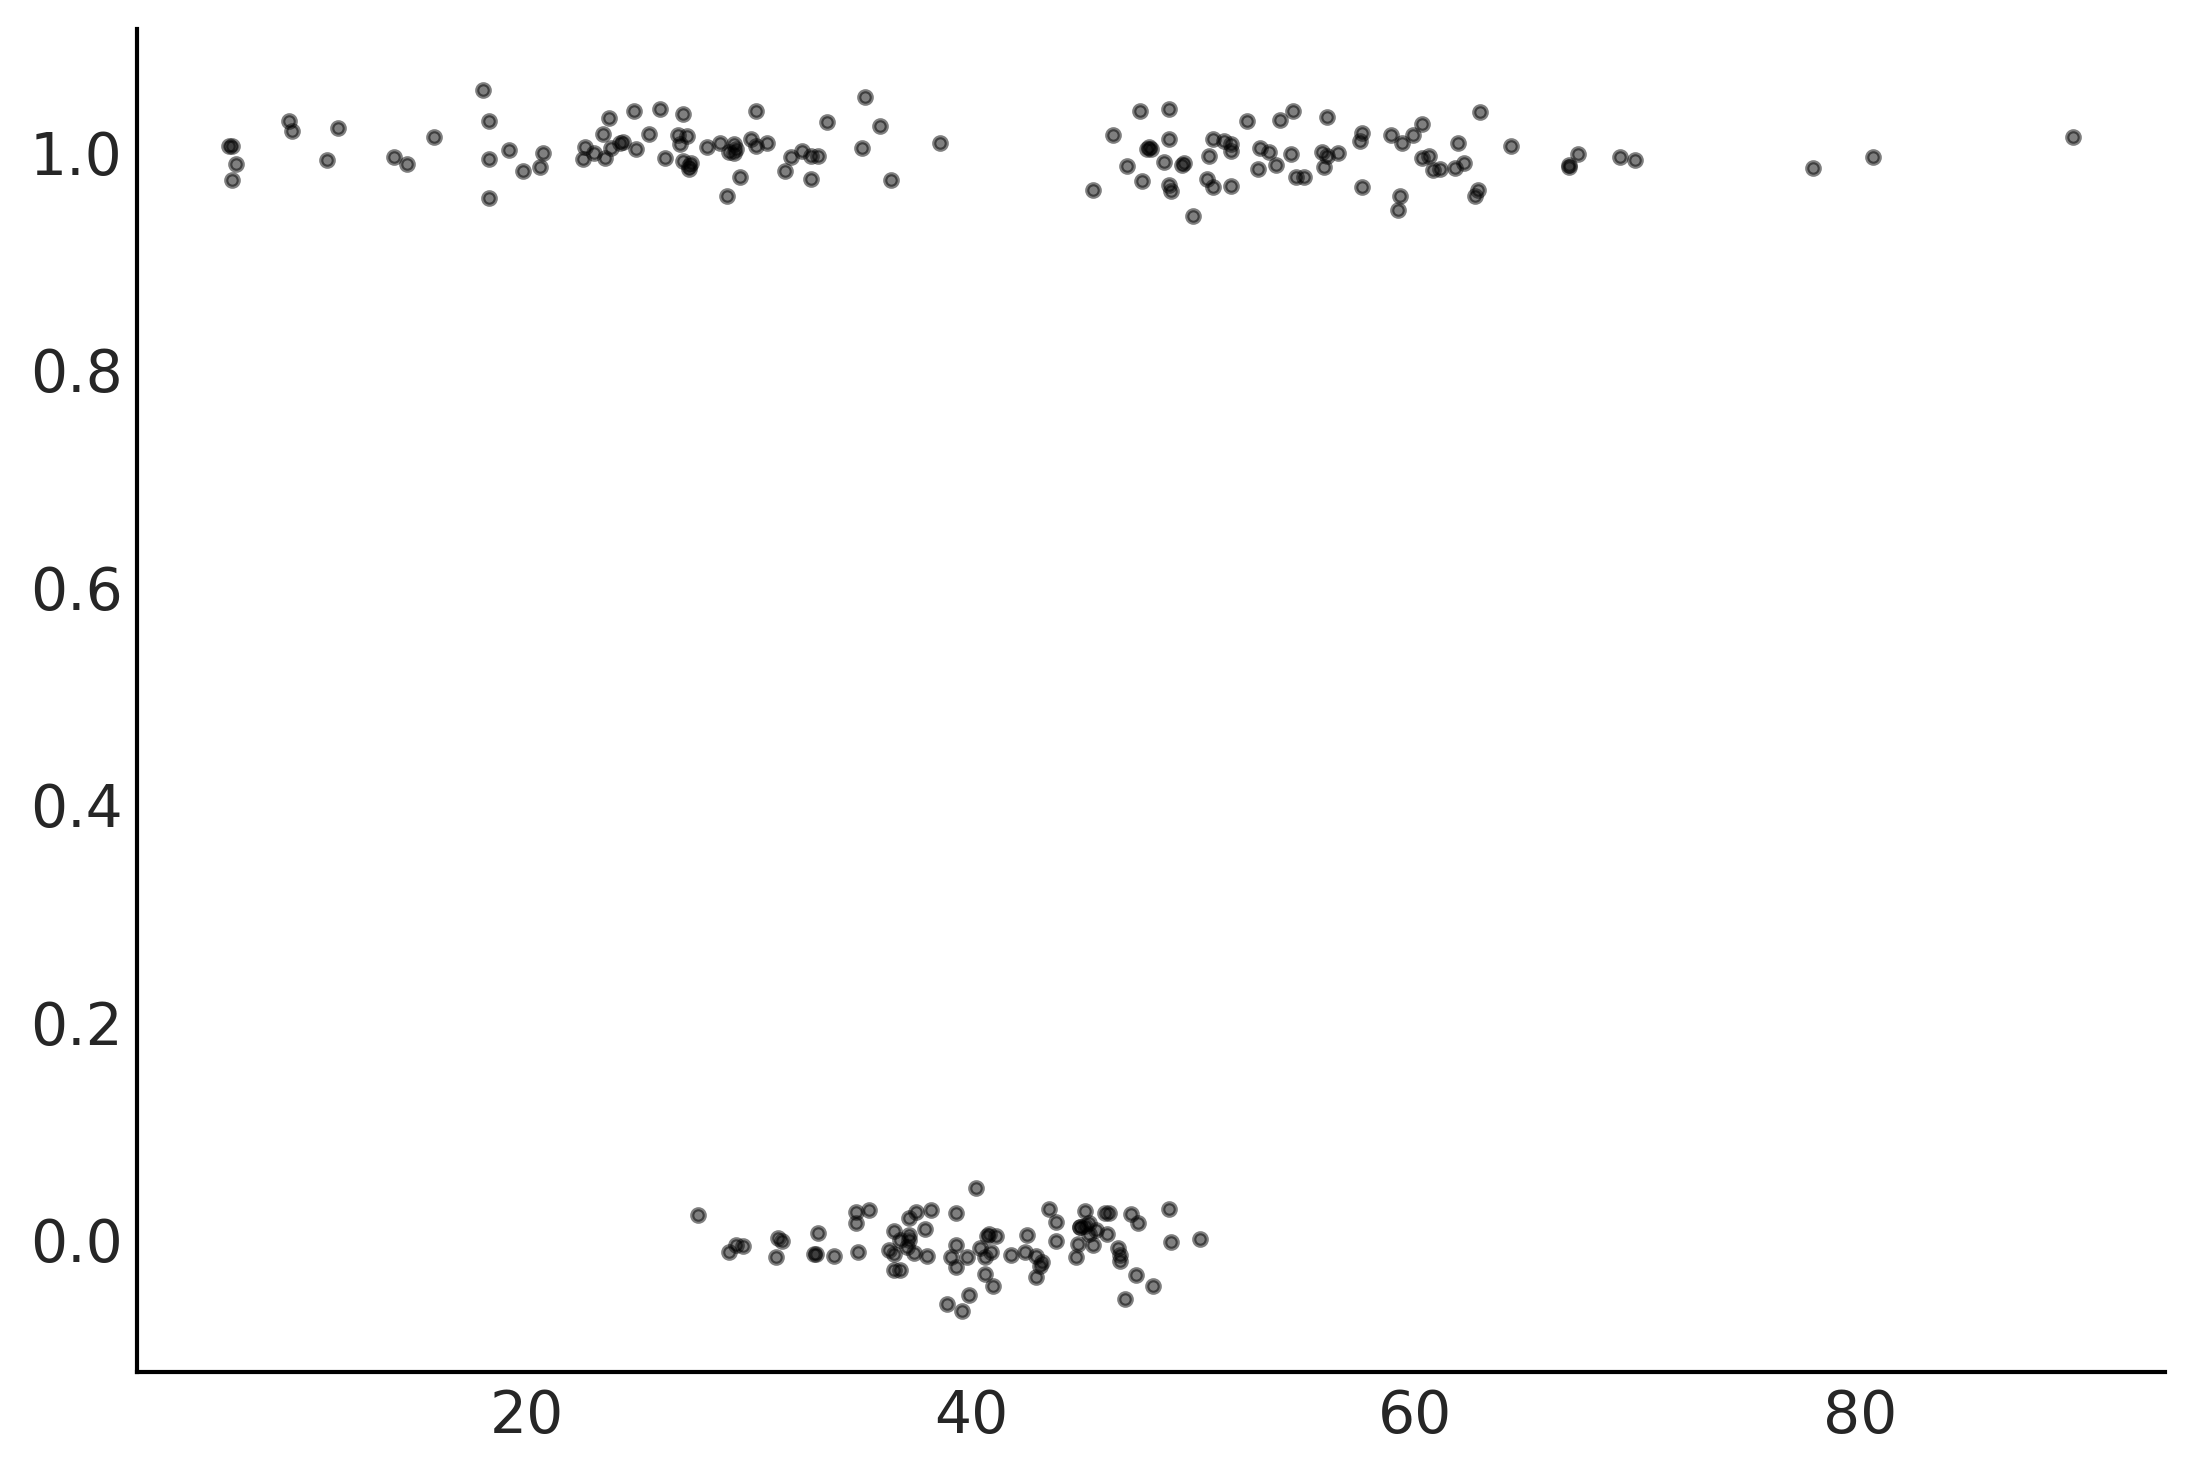

In [15]:
space_in = pd.read_csv("data/space_influenza.csv")
X = np.atleast_2d(space_in["age"]).T
Y = space_in["sick"]


Y_jittered = np.random.normal(Y, 0.02)
plt.plot(X[:,0], Y_jittered, ".", alpha=0.5)
plt.show();

### Code 7.2 and Figures 7.6 and 7.7

In [16]:
traces = []
ntrees = [2, 10, 20, 50]
for ntree in ntrees:
    with pm.Model() as bart_b:
        μ = pm.BART('μ', X, Y, m=ntree,
                    inv_link="logistic",
                   )
        y = pm.Bernoulli('y', μ, observed=Y)
        idata_bart_b = pm.sample(2000, return_inferencedata=True)
        traces.append(idata_bart_b)

The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.
The number of effective samples is smaller than 10% for some parameters.
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.
The number of effective samples is smaller than 10% for some parameters.
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [17]:
dict_cmp = dict(zip(("2", "10", "20", "50"), traces))
cmp = az.compare(dict_cmp)
cmp

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Es

rank         loo      p_loo      d_loo        weight         se       dse  \
10     0  -70.443958  12.819998   0.000000  1.000000e+00   7.387641  0.000000   
20     1  -76.117821  23.610100   5.673862  5.684342e-14   9.853547  2.604116   
2      2 -101.237317   9.563785  30.793358  0.000000e+00   3.655372  4.080170   
50     3 -108.265255  59.810081  37.821296  0.000000e+00  16.374316  9.337263   

    warning loo_scale  
10    False       log  
20     True       log  
2      True       log  
50     True       log

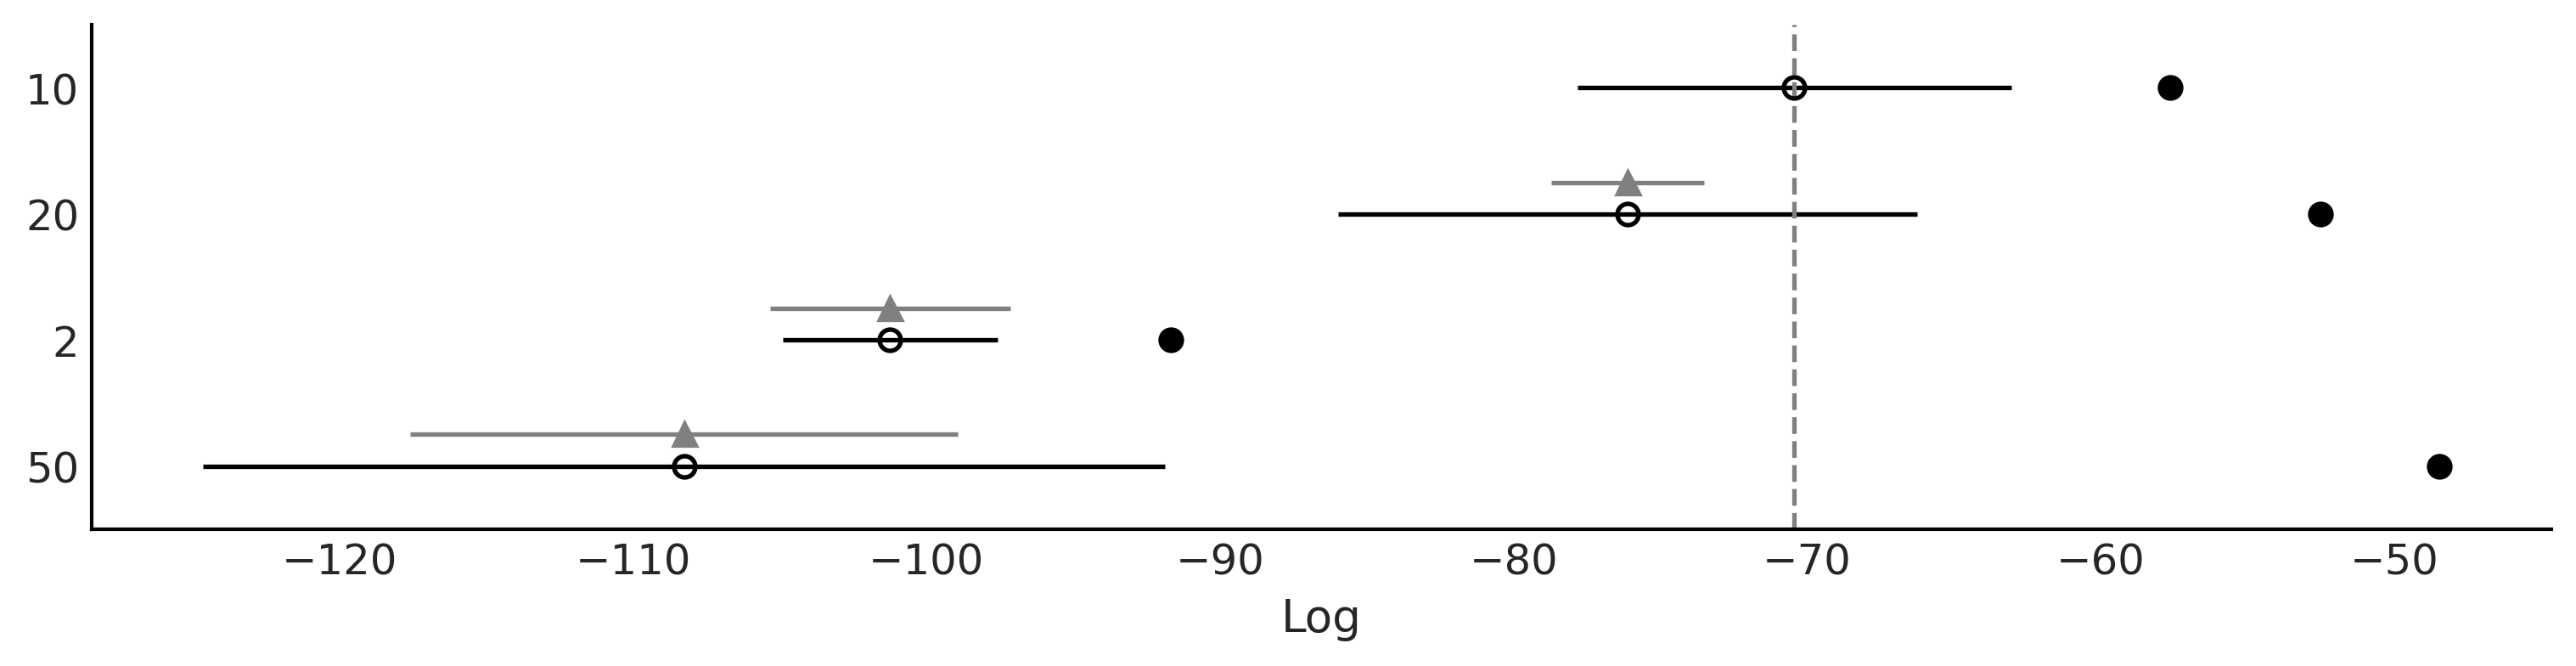

In [18]:
az.plot_compare(cmp, figsize=(10, 2.5))
# plt.savefig("img/chp07/BART_space_flu_comp.png")
plt.show();

In [19]:
fig, axes = plt.subplots(2,2, figsize=(10, 6), sharey=True, sharex=True)

for ax, trace, mtree in zip(np.ravel(axes), traces, ntrees):
    μs = trace.posterior["μ"].stack({"draws":["chain",  "draw"]})

    ax.plot(X, Y_jittered, "C1.", alpha=0.5)

    X_idx = np.argsort(X[:,0])
    ax.plot(X[:,0][X_idx], np.mean(μs, 1)[X_idx], 'k-') 
    
    az.plot_hdi(X[:,0], μs.T, ax=ax, smooth=False, color="0.5") # una banda con el 94% Highest Density Interval
    ax.set_title(mtree)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["healthy", "sick"])
fig.text(0.55, -0.04, 'Age', ha='center', size=14)
fig.text(-0.03, 0.5, 'Space Influenza', va='center', size=14, rotation=90)
# plt.savefig("img/chp07/BART_space_flu_fit.png", bbox_inches="tight")
plt.show();

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for 

## Interpretability of BARTs

### Figure 7.8

In [20]:
X = np.random.normal(0, 1, size=(3, 250)).T
Y = np.random.normal(0, 1, size=250)
X[:,0] = np.random.normal(Y, 0.1)
X[:,1] = np.random.normal(Y, 0.2)
print(X.shape, Y.shape)
print(Y[0:5])
print(X[0:5,:])
plt.plot(X, Y, '.');

(250, 3) (250,)
[0.48499944 1.05067    0.1074565  0.70213128 0.74311476]
[[ 0.49305381  0.41543062  0.03515612]
 [ 1.09438912  0.99761892 -1.14102383]
 [-0.00203998 -0.14444334  0.42842221]
 [ 0.56687498  0.66097514  0.7773232 ]
 [ 0.70684128  0.63228216  0.45133264]]


In [21]:
with pm.Model() as model:
    μ = pm.BART('μ', X, Y, m=50, alpha=0.25)
    σ = pm.HalfNormal('σ', 1)
    y = pm.Normal('y', μ, σ, observed=Y)
    trace_u = pm.sample(2000, tune=1000, chains=1, random_seed=42)

/tmp/ipykernel_1376217/618026337.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_u = pm.sample(2000, tune=1000, chains=1, random_seed=42)
The BART model is experimental. Use with caution.
Sequential sampling (1 chains in 1 job)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8933652542026335, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [22]:
idata_trace_u = az.from_pymc3(trace=trace_u)
idata_trace_u

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [23]:
plot_pdp(μ, X, grid="long", subsample=10)
# plt.savefig("img/chp07/partial_dependence_plot.png", bbox_inches="tight")
plt.show();

### Figures 7.9, 7.10, and 7.11 

In [24]:
X = data[["hour", "temperature", "humidity", "windspeed"]]
Y = data["count"]
X[0:5]

hour  temperature  humidity  windspeed
0        0         0.24      0.81     0.0000
4850     0         0.70      0.79     0.1045
5450     0         0.60      0.88     0.0000
3650     0         0.62      0.78     0.1343
6250     0         0.62      0.94     0.0896

In [25]:
with pm.Model() as bart_model_g:
    σ = pm.HalfNormal('σ', Y.std())
    μ = pm.BART('μ', X, Y, m=50)
    y = pm.Normal('y', μ, σ, observed=Y)
    trace_bart = pm.sample(2000, chains=1)

/tmp/ipykernel_1376217/616606607.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_bart = pm.sample(2000, chains=1)
The BART model is experimental. Use with caution.
Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 31 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


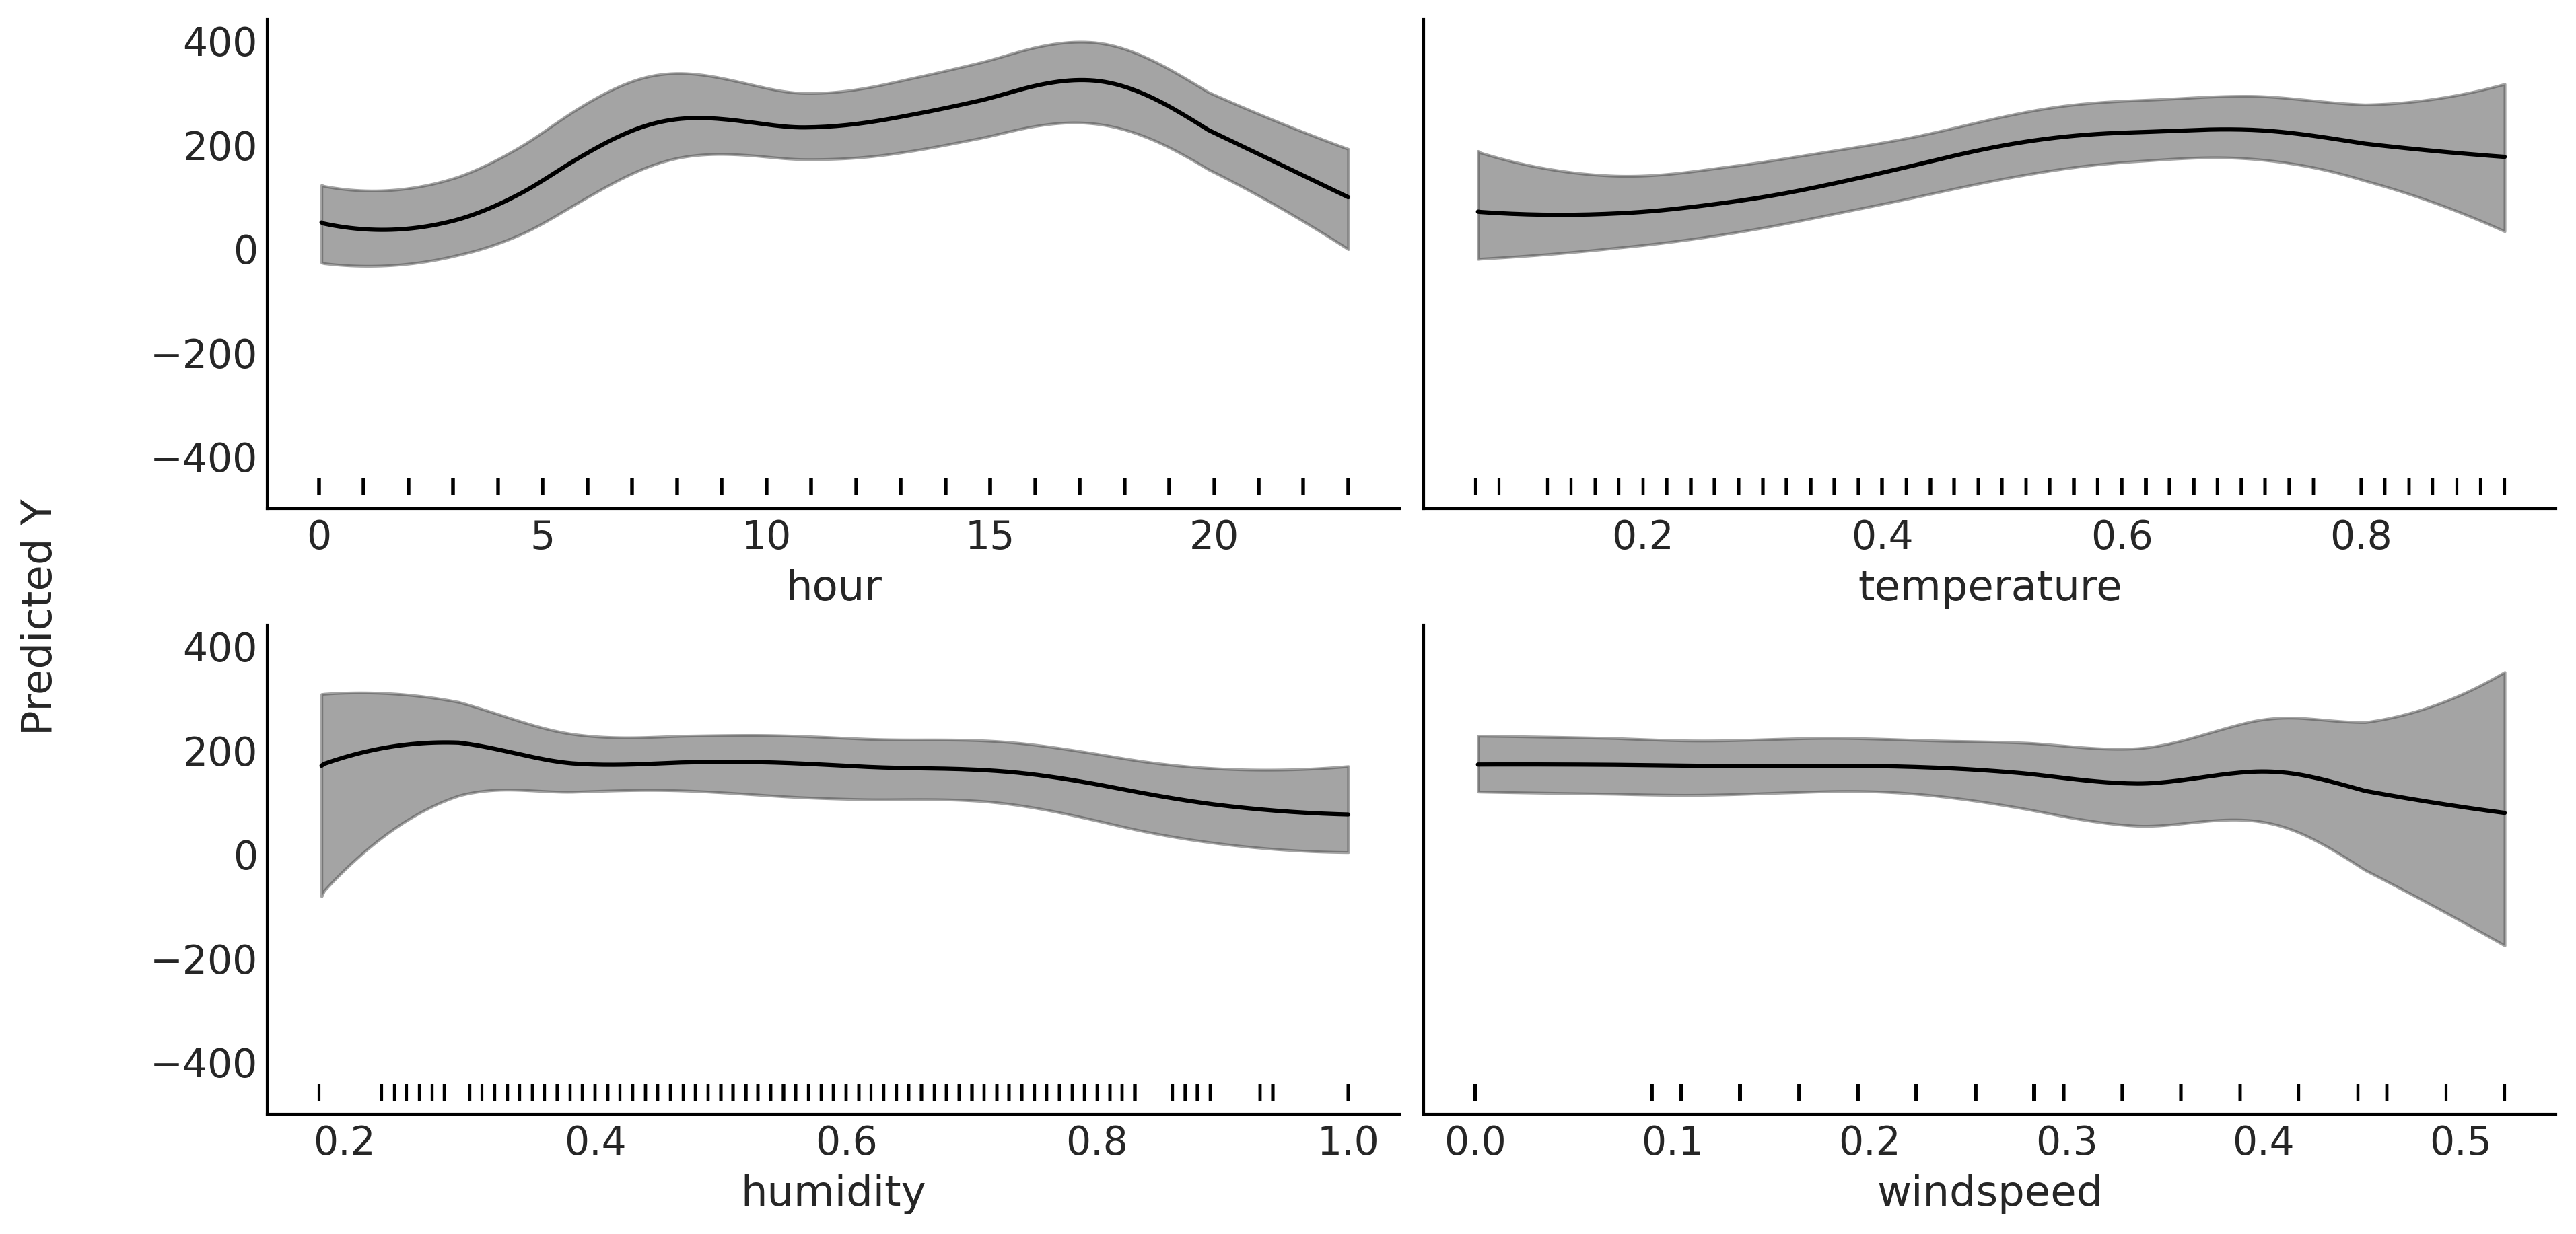

In [26]:
plot_pdp(μ, X, grid=(2, 2), figsize=(12, 6), subsample=4, sharey=True)
# plt.savefig("img/chp07/partial_dependence_plot_bikes.png", bbox_inches="tight")
plt.show();

In [27]:
# Takes forever to plot!
plot_pdp(μ, X, grid=(2,2), style="ice", subsample=15, smooth=True, color_mean="C4")
# plot_pdp(μ, X, grid=(2,2), style="ice", subsample=150, smooth=True, color_mean="C4")
# plt.savefig("img/chp07/individual_conditional_expectation_plot_bikes.png", bbox_inches="tight")
plt.show();

## Individual Conditional Expectation

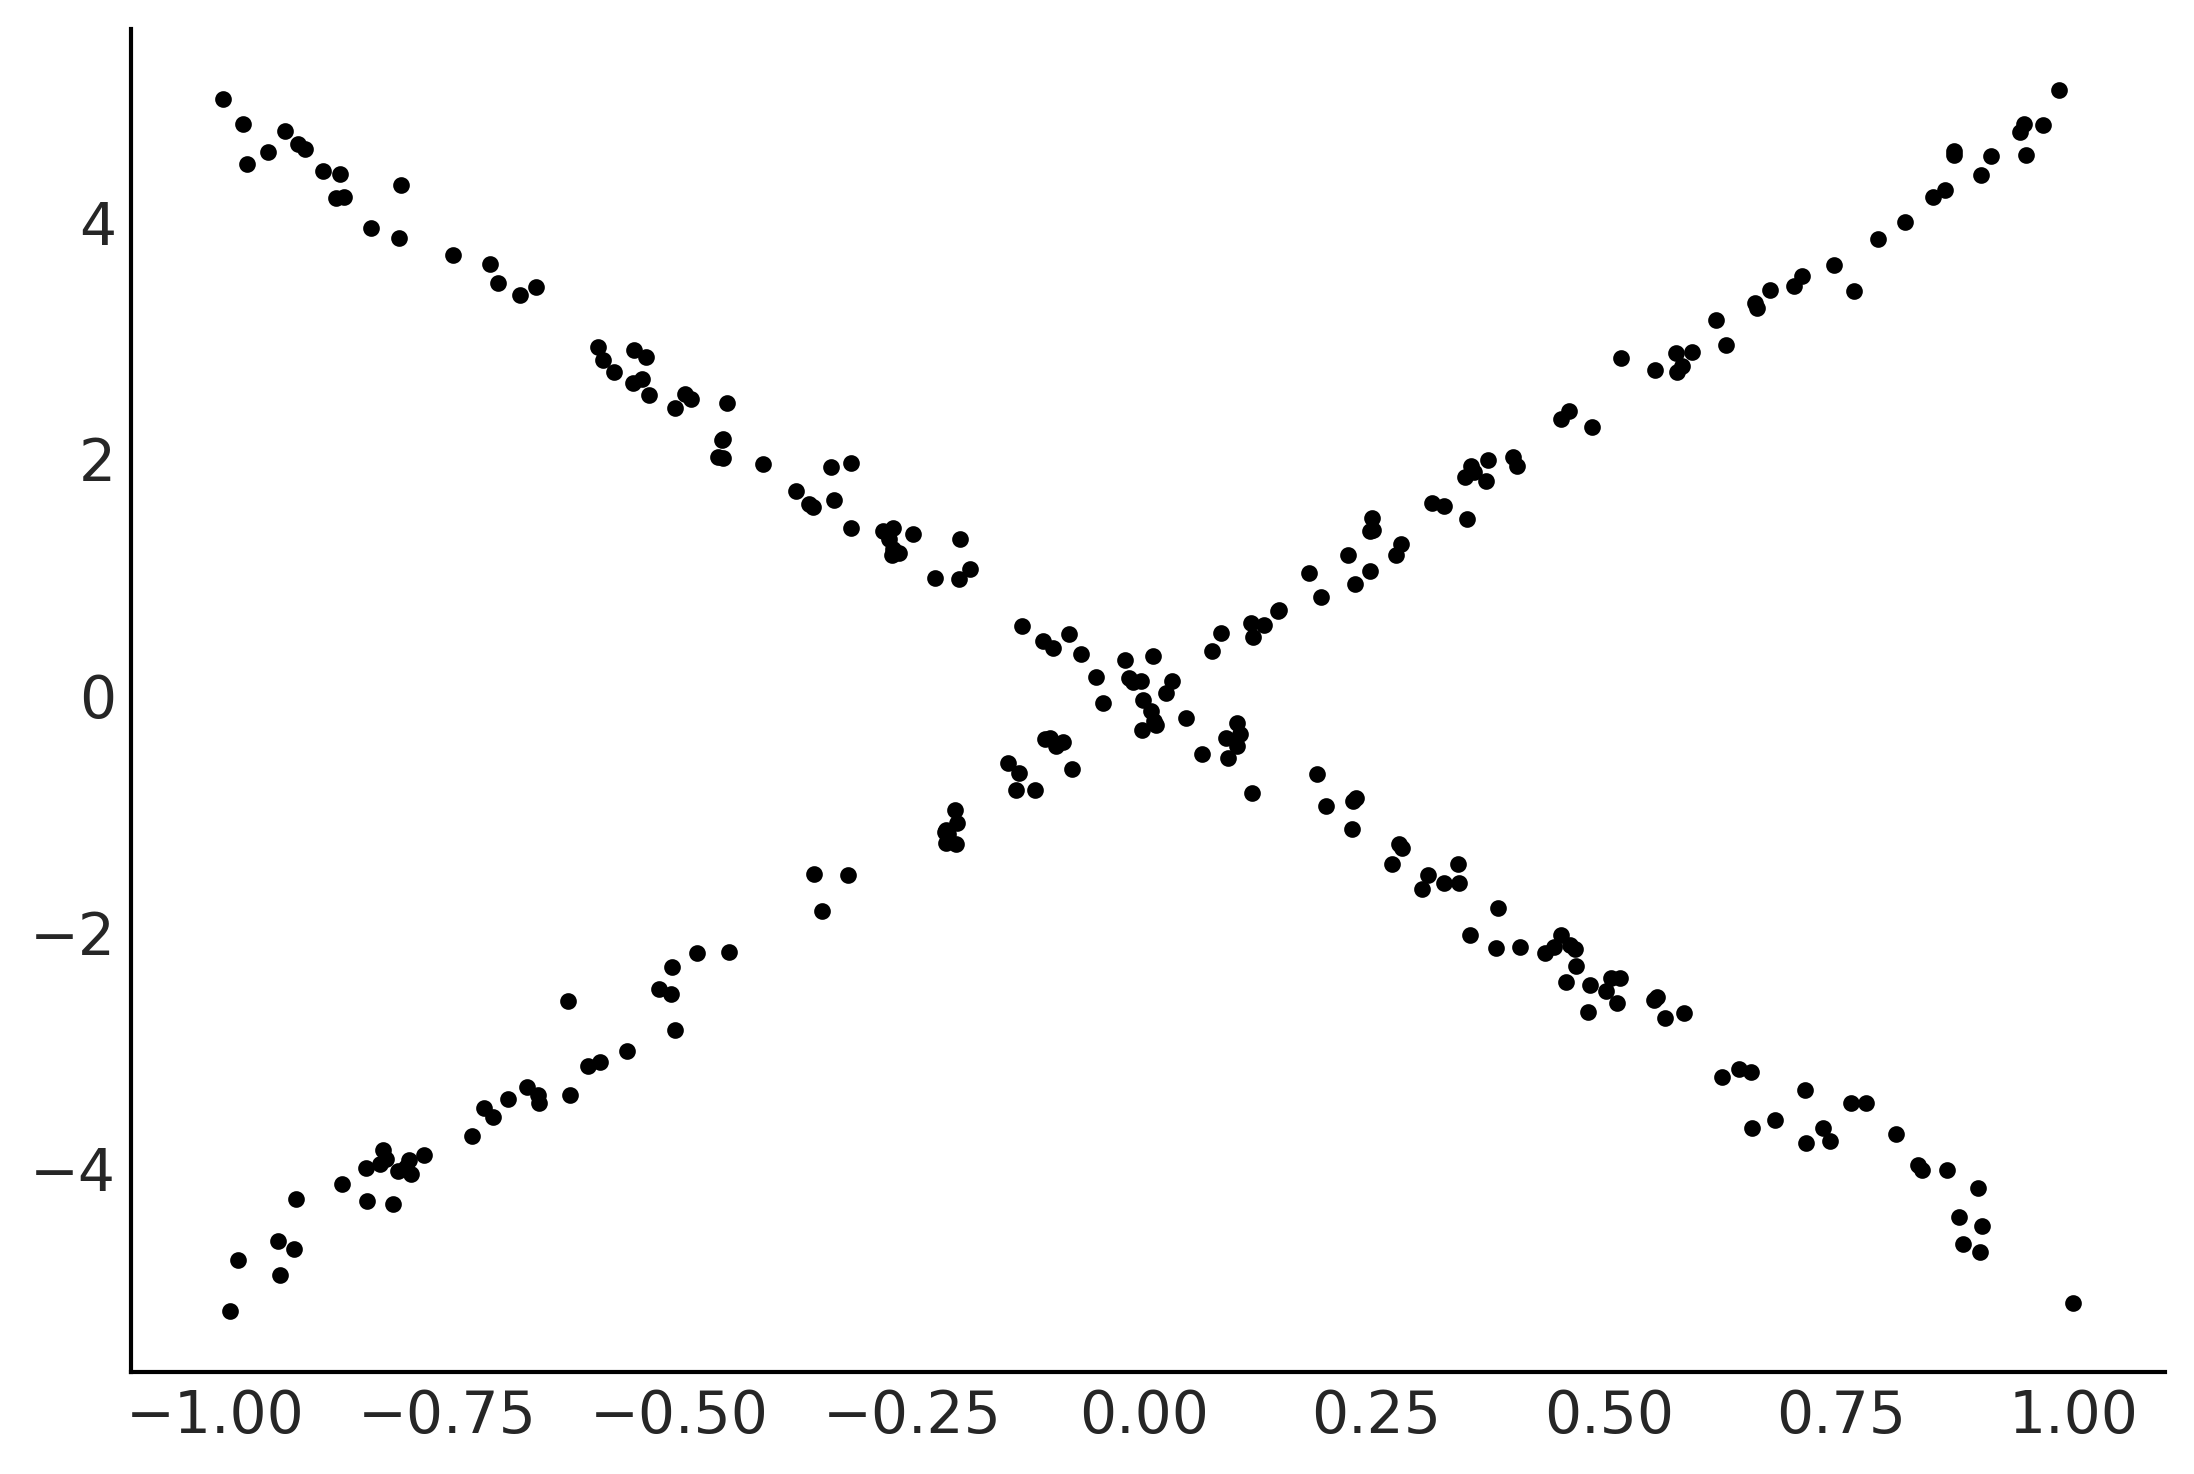

In [28]:
X = np.random.uniform(-1, 1, (250, 3))
lala = np.where(X[:,2] >= 0,  np.zeros_like(X[:,2]), np.ones_like(X[:,2]))
e = np.random.normal(0, 0.1, 250)
Y = 0.2*X[:,0] - 5*X[:,1] + 10*X[:,1] * lala+ e


plt.plot(X[:,1], Y, '.');

In [29]:
with pm.Model() as model:
    μ = pm.BART('μ', X, Y, m=50)
    σ = pm.HalfNormal('σ', 1)

    y = pm.Normal('y', μ, σ, observed=Y)
    trace_u = pm.sample(1000, tune=1000, chains=1)

/tmp/ipykernel_1376217/2147951889.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_u = pm.sample(1000, tune=1000, chains=1)
The BART model is experimental. Use with caution.
Sequential sampling (1 chains in 1 job)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [30]:
_, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True, sharex=True)
ax[0].plot(X[:,1], Y, '.');
ax[0].set_xlabel("X_1")
ax[0].set_ylabel("Observed Y")
plot_pdp(μ, X, style="pdp", smooth=True, color="C4", rug=False, var_idx=[1], ax=ax[1])
plot_pdp(μ, X, style="ice", smooth=True, subsample=100, color_mean="C4", rug=False, var_idx=[1], ax=ax[2])
# plt.savefig("img/chp07/pdp_vs_ice_toy.png", bbox_inches="tight")

[<AxesSubplot:xlabel='X_1'>]

## Variable Selection

In [31]:
Xs = []
Ys = []


Y = np.random.normal(0, 1, 100)
X = np.random.normal(0, 1, (100, 10))
X[:,0] = np.random.normal(Y, 0.1)
X[:,1] = np.random.normal(Y, 0.2)
Xs.append(X)
Ys.append(Y)


X = np.random.uniform(0, 1, size=(100, 10))
fx = 10 * np.sin(np.pi*X[:,0]* X[:,1]) + 20*(X[:,2] - 0.5)**2 + 10*X[:,3] + 5*X[:,4]
Y =  np.random.normal(fx, 1)
Xs.append(X)
Ys.append(Y)


Y = np.random.normal(0, 1, 100)
X = np.random.normal(0, 1, (100, 10))
Xs.append(X)
Ys.append(Y)

In [32]:
traces = []

for X, Y in zip(Xs, Ys):
    for m in [25, 50, 100, 200]:
        with pm.Model() as bart:
            σ = pm.HalfNormal('σ', Y.std())
            μ = pm.BART('μ', X, Y, m=m)
            y = pm.Normal('y', μ, σ, observed=Y)
            traces.append(pm.sample())

/tmp/ipykernel_1376217/3284104478.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.6717652813482132, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/tmp/ipykernel_1376217/3284104478.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.87989173580117, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/tmp/ipykernel_1376217/3284104478.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
The acceptance probability does not match the target. It is 0.891365414783855, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9167829362275677, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/tmp/ipykernel_1376217/3284104478.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
The acceptance probability does not match the target. It is 0.8980294561416986, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8792440688341344, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8944006055161231, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/tmp/ipykernel_1376217/3284104478.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence t

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The number of effective samples is smaller than 10% for some parameters.
/tmp/ipykernel_1376217/3284104478.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
The number of effective samples is smaller than 25% for some parameters.
/tmp/ipykernel_1376217/3284104478.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
The acceptance probability does not match the target. It is 0.8900750333868745, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8814107832072631, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/tmp/ipykernel_1376217/3284104478.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.
The acceptance probability does not match the target. It is 0.9014601140761308, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/tmp/ipykernel_1376217/3284104478.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The number of effective samples is smaller than 10% for some parameters.
/tmp/ipykernel_1376217/3284104478.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
The number of effective samples is smaller than 25% for some parameters.
/tmp/ipykernel_1376217/3284104478.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
The number of effective samples is smaller than 10% for some parameters.
/tmp/ipykernel_1376217/3284104478.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 107 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


### Figure 7.12

In [33]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
ax = np.ravel(ax)

count = 0
for j, X in enumerate(Xs):
    ax[j].set_prop_cycle(cycler('color', viridish))
    for i, m in enumerate([25, 50, 100, 200]):
        ax[j].axhline(1/X.shape[1], color="k", ls=":")
        ax[j].plot(traces[count].report.variable_importance, label=f"m={m}", lw=3, marker="o")
        ax[j].set_xticks(range(X.shape[1]))
        ax[j].set_xticklabels([f"$X_{i}$" for i in range(X.shape[1])], fontsize=12)

        count += 1
fig.text(0.5, -0.05, 'Independent variable', ha='center', fontsize=15)
fig.text(-0.05, 0.5, 'Relative variable importance', va='center', rotation='vertical', fontsize=15)
ax[0].legend()
        
# plt.savefig("img/chp07/bart_vi_toy.png", bbox_inches="tight")

In [34]:
data = pd.read_csv("data/bikes_hour.csv")
data.sort_values(by='hour', inplace=True)
data = data[::50]
X = data[["hour", "temperature", "humidity", "windspeed"]]
Y = data["count"]

In [35]:
traces = []

for m in [25, 50, 100]:
    with pm.Model() as bart:
        σ = pm.HalfNormal('σ', Y.std())
        μ = pm.BART('μ', X, Y, m=m)
        y = pm.Normal('y', μ, σ, observed=Y)
        traces.append(pm.sample())

/tmp/ipykernel_1376217/789580105.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The acceptance probability does not match the target. It is 0.8837202274285543, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8787818201911145, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/tmp/ipykernel_1376217/789580105.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
The number of effective samples is smaller than 25% for some parameters.
/tmp/ipykernel_1376217/789580105.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample())
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
The number of effective samples is smaller than 25% for some parameters.


### Figure 7.13

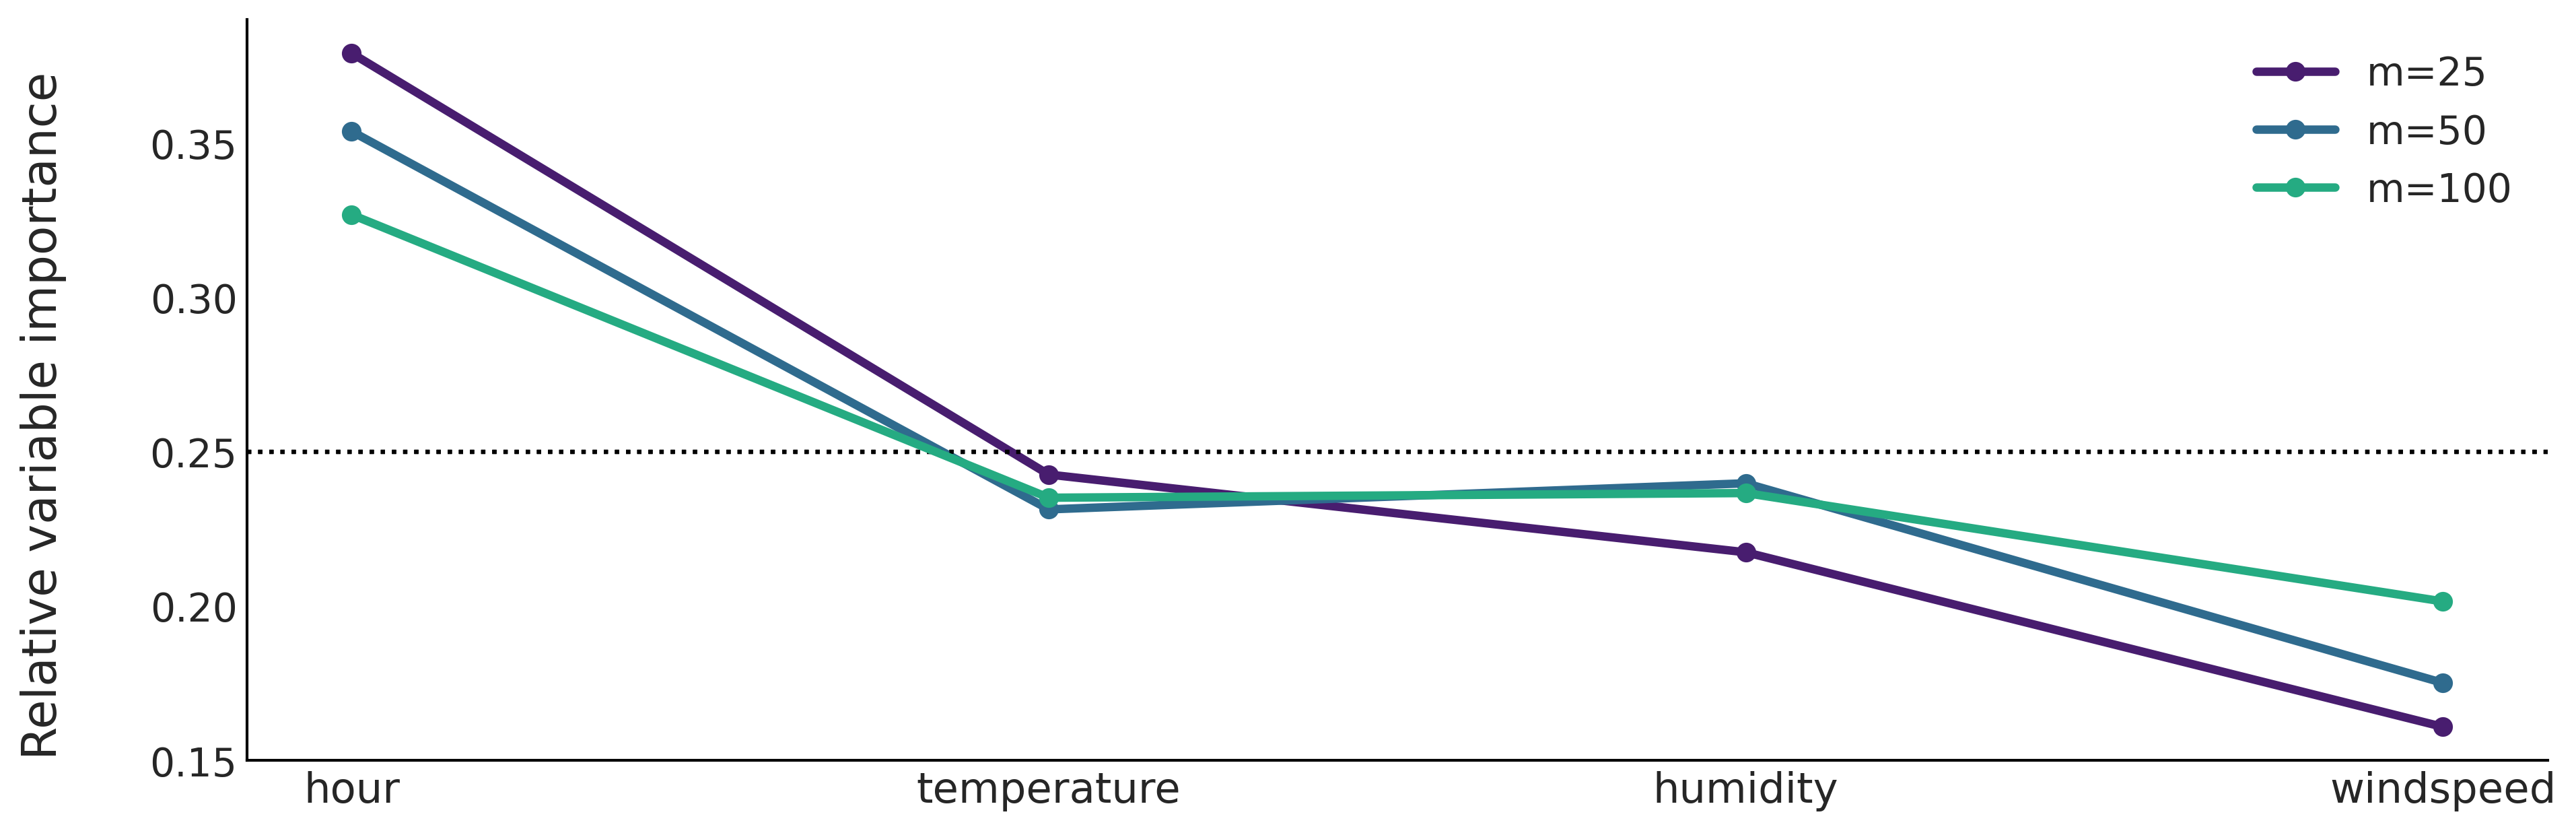

In [36]:
fig, ax = plt.subplots(sharey=True, figsize=(12, 4))
ax.set_prop_cycle(cycler('color', viridish))
ax = np.ravel(ax)

count = 0
for i, m in enumerate([25, 50, 100]):
    ax[0].axhline(1/X.shape[1], color="k", ls=":")
    ax[0].plot(traces[count].report.variable_importance, label=f"m={m}", lw=3, marker="o")
    ax[0].set_xticks(range(X.shape[1]))
    ax[0].set_xticklabels([label for label in X.columns], fontsize=15)

    count += 1
fig.text(-0.05, 0.5, 'Relative variable importance', va='center', rotation='vertical', fontsize=17)
ax[0].legend()
        
# plt.savefig("img/chp07/bart_vi_bikes.png", bbox_inches="tight")